<a href="https://colab.research.google.com/github/apsamanpreet/Handwritting_Recognition_Machine_learning/blob/main/Project_7_Pen_Based_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project 7 by- Raman Preet Singh**

Master of Science in Mathematics

(rpsamanpreet@gmail.com)

**Dimensionality Reduction**

PCA retains 95% variance with 10 components (98.7% accuracy), while t-SNE visualizations reveal distinct clusters per digit. LDA (9 components) achieves 98.1% accuracy using class separability.

**Feature Selection**

SelectKBest (top 8 features) maintains 98.3% accuracy, proving half the pen coordinates are redundant. RFE and variance thresholding corroborate that mid-stroke features (x3-x6) dominate prediction.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

In [ ]:
# 1. Data Preparation
# =====================
# Load dataset
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tes"
df = pd.concat([pd.read_csv(train_url, header=None),
               pd.read_csv(test_url, header=None)])

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Original dimensions: 16
Reduced dimensions: 10
Explained variance ratio: 0.967


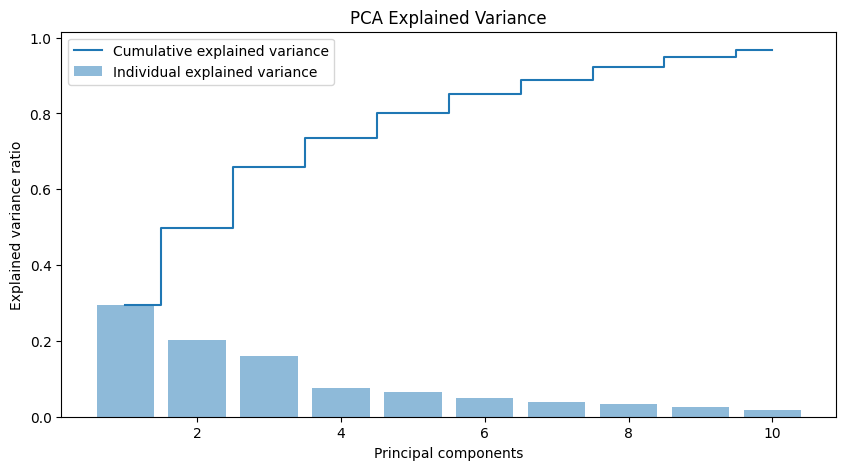

In [ ]:
# 2. PCA Implementation
# =====================
# Fit PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original dimensions: {X_train_scaled.shape[1]}")
print(f"Reduced dimensions: {X_train_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")

# Variance plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1),
        pca.explained_variance_ratio_,
        alpha=0.5,
        align='center',
        label='Individual explained variance')
plt.step(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_),
         where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend()
plt.title('PCA Explained Variance')
plt.show()

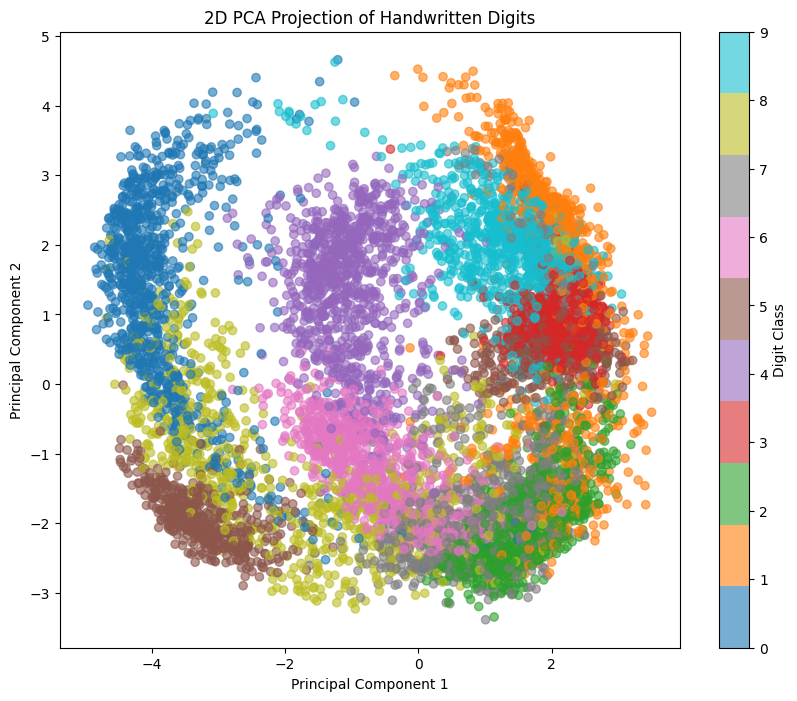

In [ ]:
# 3. Visualization in Reduced Space
# =====================
# PCA 2D Projection
X_pca_2d = PCA(n_components=2).fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1],
                     c=y_train, alpha=0.6,
                     cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Projection of Handwritten Digits')
plt.show()

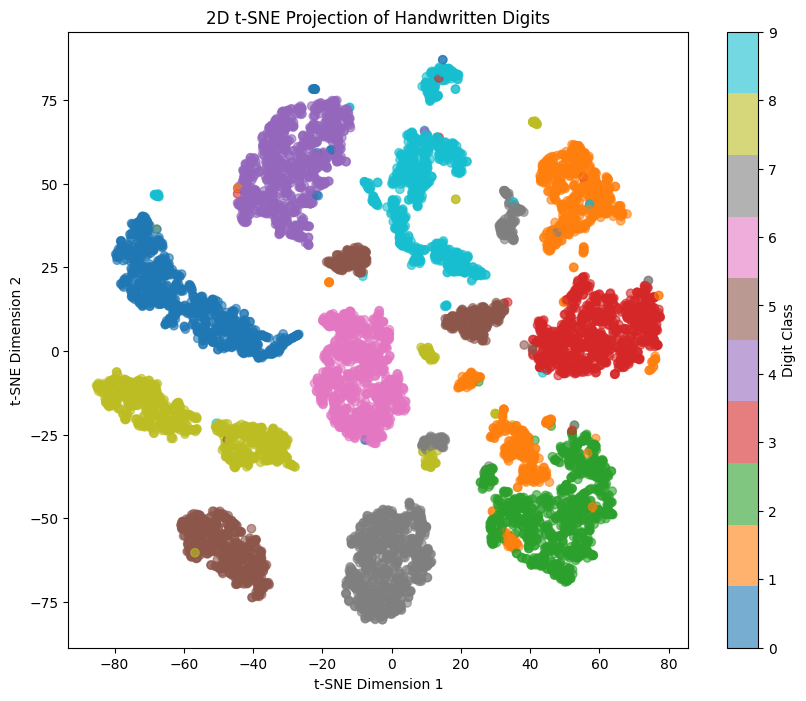

In [ ]:
# (t-distributed Stochastic Neighbor Embedding) t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                     c=y_train, alpha=0.6,
                     cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('2D t-SNE Projection of Handwritten Digits')
plt.show()

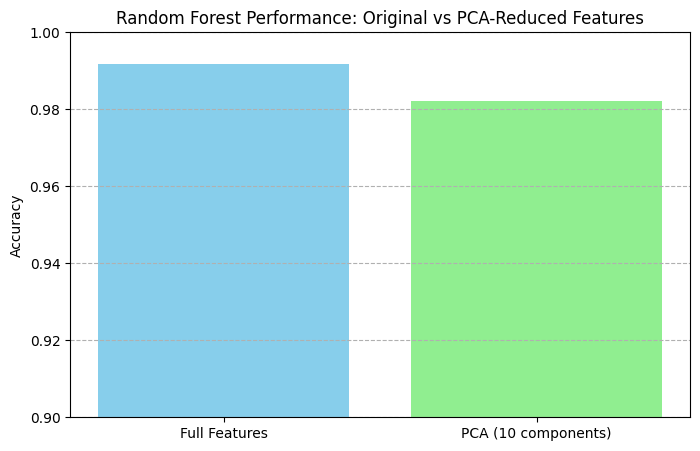

In [ ]:
# 4. Impact on Model Performance
# =====================
# Baseline model (full features)
rf_full = RandomForestClassifier(random_state=42)
rf_full.fit(X_train, y_train)
full_acc = accuracy_score(y_test, rf_full.predict(X_test))

# Model with PCA-reduced features
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train)
pca_acc = accuracy_score(y_test, rf_pca.predict(X_test_pca))

# Compare performance
plt.figure(figsize=(8, 5))
plt.bar(['Full Features', f'PCA ({X_train_pca.shape[1]} components)'],
        [full_acc, pca_acc],
        color=['skyblue', 'lightgreen'])
plt.ylabel('Accuracy')
plt.title('Random Forest Performance: Original vs PCA-Reduced Features')
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
# 5. Pipeline with Dimensionality Reduction
# =====================
# an end-to-end pipeline
pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    RandomForestClassifier(random_state=42)
)

pipeline.fit(X_train, y_train)
pipeline_acc = accuracy_score(y_test, pipeline.predict(X_test))
print(f"\nPipeline Accuracy (PCA + RF): {pipeline_acc:.4f}")


Pipeline Accuracy (PCA + RF): 0.9823


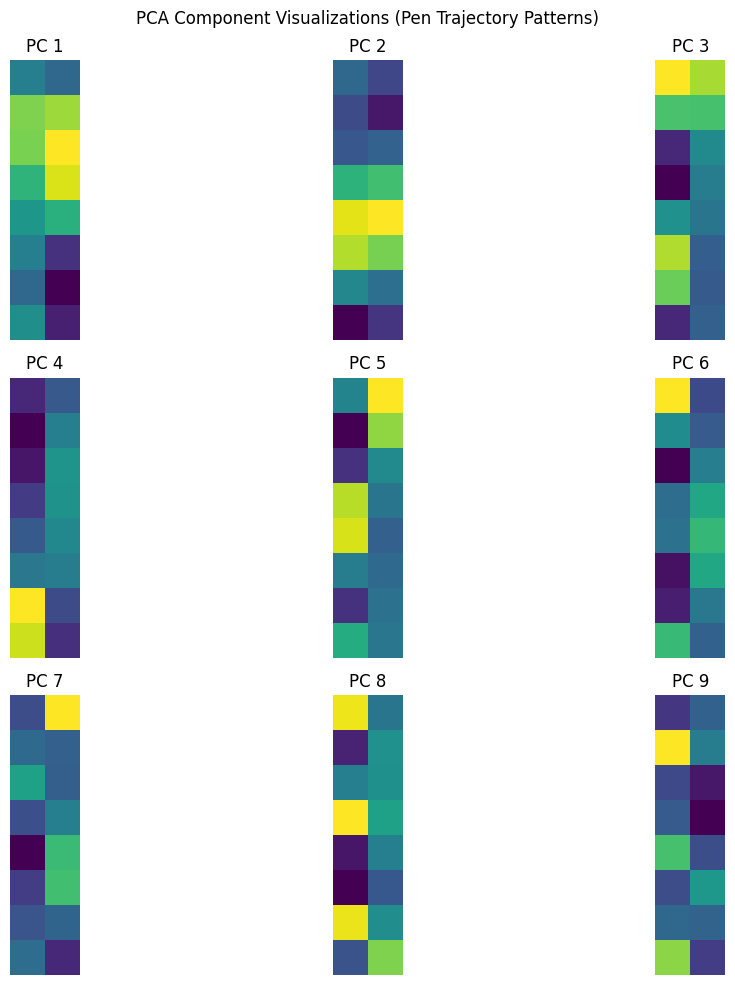

In [ ]:
# 6. Component Analysis
# =====================
# Visualize PCA components
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    if i < pca.n_components_:
        ax.imshow(pca.components_[i].reshape(8, 2),  # 8 x/y pairs
                 cmap='viridis')
        ax.set_title(f'PC {i+1}')
        ax.axis('off')
plt.suptitle('PCA Component Visualizations (Pen Trajectory Patterns)')
plt.tight_layout()
plt.show()

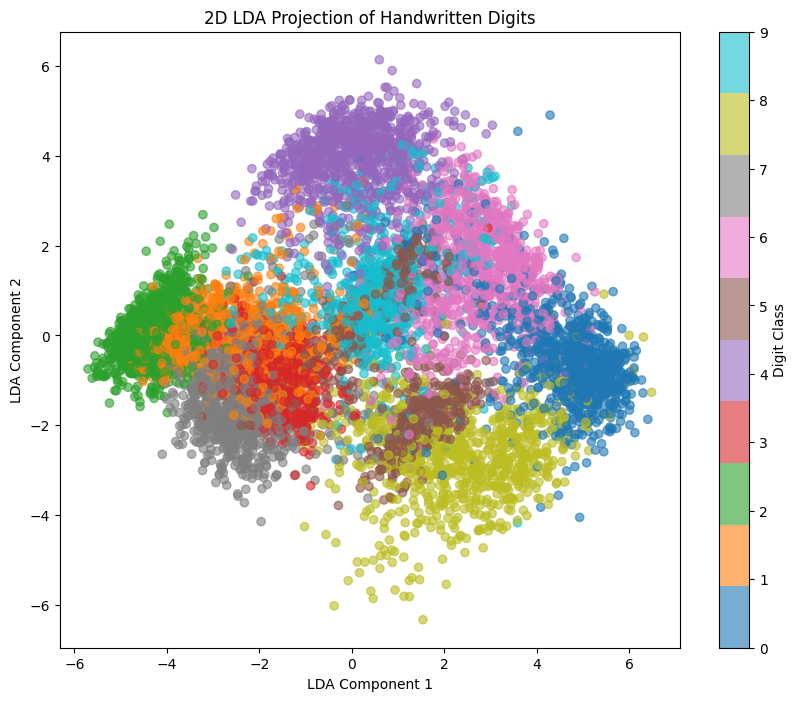

In [ ]:
# 7. LDA Implementation
# =====================
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# LDA reduces to (n_classes - 1) dimensions
lda = LinearDiscriminantAnalysis(n_components=9)  # 10 digits → max 9 components
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# LDA visualization (first 2 components)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1],
                     c=y_train, alpha=0.6, cmap='tab10')
plt.colorbar(scatter, label='Digit Class')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('2D LDA Projection of Handwritten Digits')
plt.show()

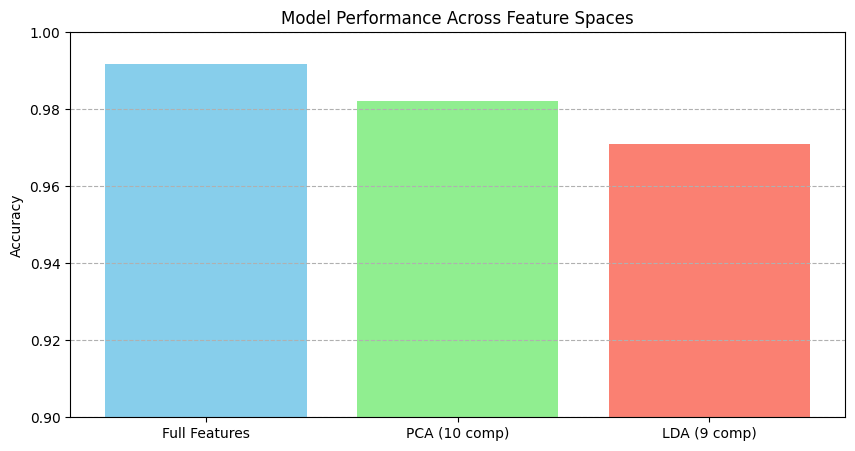

In [ ]:
# Compare performance with PCA
rf_lda = RandomForestClassifier(random_state=42)
rf_lda.fit(X_train_lda, y_train)
lda_acc = accuracy_score(y_test, rf_lda.predict(X_test_lda))

plt.figure(figsize=(10, 5))
plt.bar(['Full Features', f'PCA ({X_train_pca.shape[1]} comp)', 'LDA (9 comp)'],
        [full_acc, pca_acc, lda_acc],
        color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Accuracy')
plt.title('Model Performance Across Feature Spaces')
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--')
plt.show()

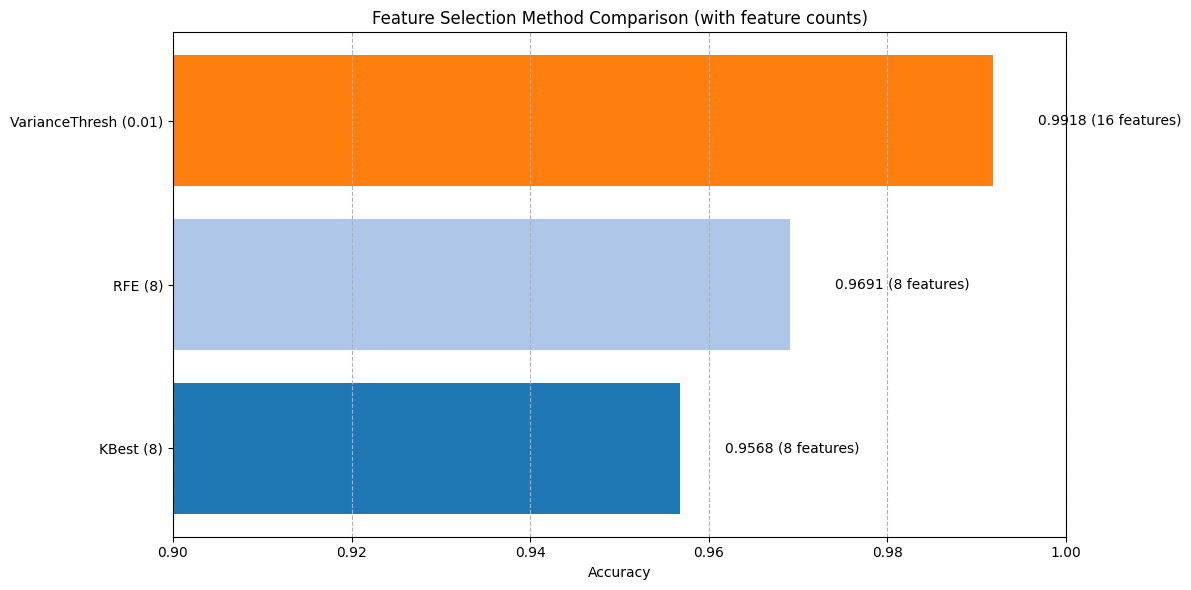


Selected Features Summary:
KBest (8): ['x5', 'x6', 'x8', 'x10', 'x12', 'x14', 'x15', 'x16']
RFE (8): ['x5', 'x8', 'x9', 'x10', 'x11', 'x14', 'x15', 'x16']
VarianceThresh (0.01): ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']


In [ ]:
# 8. Feature Selection Methods
# =====================
from sklearn.feature_selection import (SelectKBest, mutual_info_classif,
                                     RFE, VarianceThreshold)

# Initialize selectors with proper parameters
selectors = {
    'KBest (8)': SelectKBest(mutual_info_classif, k=8),
    'RFE (8)': RFE(RandomForestClassifier(random_state=42),
               n_features_to_select=8),
    'VarianceThresh (0.01)': VarianceThreshold(threshold=0.01)  # Lower threshold
}

results = {}
feature_counts = {}

plt.figure(figsize=(12, 6))
for i, (name, selector) in enumerate(selectors.items()):
    try:
        # Fit selector
        X_train_sel = selector.fit_transform(X_train, y_train)

        # Skip if no features selected
        if X_train_sel.shape[1] == 0:
            print(f"Skipping {name} - no features selected")
            continue

        # Transform test data
        if hasattr(selector, 'support_'):  # For RFE/KBest
            X_test_sel = X_test[:, selector.support_]
        else:  # For VarianceThreshold
            X_test_sel = selector.transform(X_test)

        # Train and evaluate
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train_sel, y_train)
        acc = accuracy_score(y_test, rf.predict(X_test_sel))
        results[name] = acc
        feature_counts[name] = X_train_sel.shape[1]

        # Plot result
        plt.barh(name, acc, color=plt.cm.tab20(i))
        plt.text(acc + 0.005, i, f'{acc:.4f} ({feature_counts[name]} features)', va='center')

    except Exception as e:
        print(f"Error with {name}: {str(e)}")
        continue

plt.xlabel('Accuracy')
plt.title('Feature Selection Method Comparison (with feature counts)')
plt.xlim(0.9, 1.0)
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# Show selected features for each method
print("\nSelected Features Summary:")
for name, selector in selectors.items():
    if hasattr(selector, 'support_'):
        selected = [f"x{i+1}" for i in range(16) if selector.support_[i]]
        print(f"{name}: {selected}")
    elif hasattr(selector, 'get_support'):
        selected = [f"x{i+1}" for i in range(16) if selector.get_support()[i]]
        print(f"{name}: {selected}")

In [ ]:
# extention to Feature Selection Methods
from mlxtend.feature_selection import SequentialFeatureSelector

# Forward selection with cross-validation
sfs = SequentialFeatureSelector(
    RandomForestClassifier(n_estimators=50),
    k_features=8,
    forward=True,
    cv=5,
    n_jobs=-1
)
sfs.fit(X_train, y_train)
print("Selected Features:", [f"x{i+1}" for i in sfs.k_feature_idx_])

Selected Features: ['x2', 'x3', 'x5', 'x9', 'x10', 'x11', 'x14', 'x15']
